# Investigating California's large energy-storage system pricing through Self-Generation Incentive Program's Public data

import libraries and data

In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [3]:
sgip_data = pd.read_excel('sgip data/sgip data.xlsx')

In [4]:
sgip_data.columns = sgip_data.iloc[2,:]

In [5]:
sgip_data.drop([0,1,2],axis = 0, inplace = True)

In [6]:
sgip_data.columns

Index(['SGIP Administrator', 'Application Code', 'Program Year', 'Step',
       'Budget Category', 'Fully Qualified State', 'Equipment Type',
       'Rated Capacity [kW]', 'Energy Storage Capacity (kWh)', 'Fuel Type',
       'Biogas Source', 'Renewable (%)', 'Paired With Renewable',
       'Paired With', 'Equipment Manufacturer', 'Fuel Incentive ($)',
       'Equipment Incentive ($)', 'Current Incentive ($)',
       'Incentive Level (1, 2(R/ET), 3(NR))', 'Budget Classification',
       'Type of Other Incentive', 'Other Incentive Amount ($)',
       'Total Eligible Costs', 'Developer Company Name',
       'Host Customer Sector', 'Host Customer SIC/NAICS Code', 'City',
       'County', 'Zip', 'West LA LRA', 'Electric Utility', 'Gas Utility',
       'Installer Name', 'Date Received', 'RRF Submitted',
       'Interconnection date', 'Payment Completed Date', 'Cancelled Date'],
      dtype='object', name=2)

## Filter out data that is irrelevant to large storage systems

> We need to first filter out small storages system from the data by using k-means to cluster energy storage systems based on their storage capacity and filtering out  the clusters that are small.

> Using the elbow plot to compute the optimal number of clusters

In [7]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


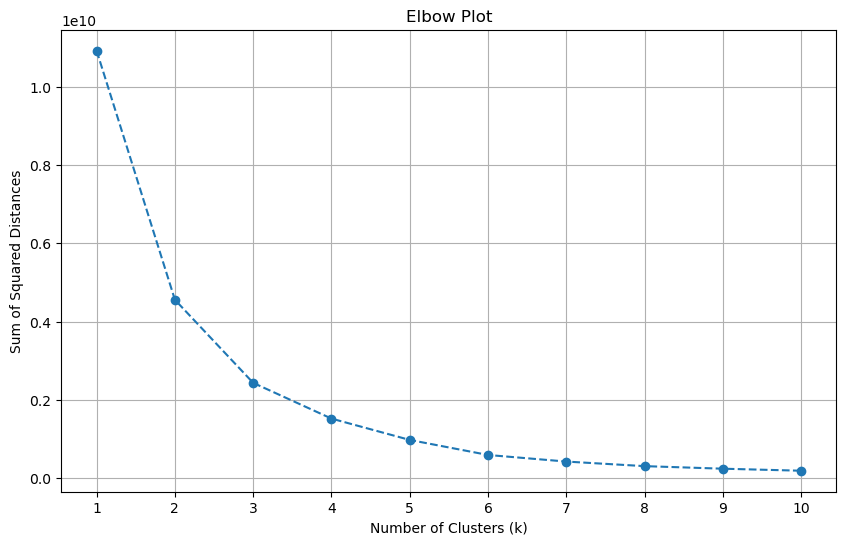

In [8]:
energy_storage_capacity = sgip_data['Energy Storage Capacity (kWh)'].dropna()
energy_storage_capacity = np.array(energy_storage_capacity).reshape(-1,1)

max_k = 10
sum_of_squared_distances = []

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(energy_storage_capacity)
    sum_of_squared_distances.append(kmeans.inertia_)  
    
plt.figure(figsize=(10,6))
plt.plot(range(1, max_k+1), sum_of_squared_distances, marker='o', linestyle='--')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.xticks(range(1, max_k+1))
plt.grid(True)
plt.show()

In [9]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(energy_storage_capacity)
kWh_cluster_labels = kmeans.labels_

From the mean size of each cluster suggested below, we can see that cluster 0 represent small storage systems, which have an average storage capacity of 23kWh.

In [10]:
kmeans.cluster_centers_

array([[   23.92651725],
       [ 4678.60301575],
       [  751.43076834],
       [ 9580.28662069],
       [22892.33333333],
       [ 2262.42185918]])

 After checking the distribution of system size, we can tell that the maximum size of cluster 0 is around 386 kWh. Since Tesla's Megapack has a storage capacity of over 1MWh, we can reasonably assume that cluster 0 are/were not competitor products of Megapack. Therefore, in the analysis below, we will filter out all cluster 0 storage systems. 

In [11]:
kWh_study = pd.DataFrame({'kWh':sgip_data['Energy Storage Capacity (kWh)'].dropna(),'cluster':kWh_cluster_labels})

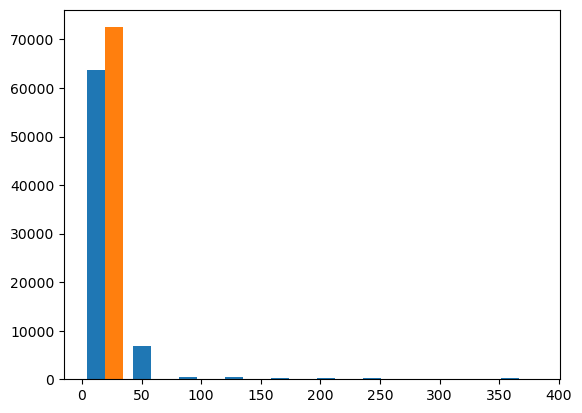

max storage capacity of cluster 0 is: 386


In [12]:
max_size_of_cluster_0 = kWh_study[kWh_study['cluster'] == 0]['kWh'].max()
plt.hist(kWh_study[kWh_study['cluster'] == 0])
plt.show()
print('max storage capacity of cluster 0 is:', max_size_of_cluster_0)

Filter out cluster 0

In [13]:
sgip1 = sgip_data[sgip_data['Energy Storage Capacity (kWh)'] > max_size_of_cluster_0 ]

Filter out systems whose rebate were rejected, cancelled, unapproved, or waitlisted, because these status indicate that the systems were not purchased or installed.

In [14]:
sgip2 = sgip1[~sgip1['Fully Qualified State'].isin(['RRF Rejected','RRF Waitlist', 'RRF Technical Review','RRF Suspended','Cancelled','RRF Review','RRF Submitted','RRF Resubmitted'])]

Checking the status of the applications process of the batteries to make sure they are valid batteries

In [15]:
sgip2 ['Fully Qualified State'].value_counts()

Fully Qualified State
Payment PBI in Process      568
ICF Draft                   199
PPM Confirmed               169
Payment Completed           130
RRF Reserved                 48
PPM Draft                    41
PPM Suspended                19
ICF Inspection               13
ICF Suspended                12
ICF Pending Payment          11
PPM Technical Review          5
ICF Technical Review          4
PPM Review                    3
ICF Review                    2
ICF Inspection Suspended      2
ICF Submitted                 1
ICF Equipment Review          1
ICF Resubmitted               1
PPM Resubmitted               1
Name: count, dtype: int64

In [16]:
df = sgip2 [['Energy Storage Capacity (kWh)','Zip','Interconnection date',
            'Total Eligible Costs', 'Developer Company Name','Installer Name','Fully Qualified State','Host Customer Sector']]

Since there are two columns that suggest the competitors ('Developer Company Name' and 'Installer Name'), and both include missing values, we need to unify the two installer columns to make sure we extract as much information as possible.

In [17]:
print('Missing values of the installer columns')
df[['Developer Company Name','Installer Name']].isna().sum()

Missing values of the installer columns


2
Developer Company Name    156
Installer Name             54
dtype: int64

In [18]:
df['Developer Company Name'].value_counts()[:25]

Developer Company Name
Tesla Inc.                                                                        221
Stem, Inc.                                                                         87
SolarCity Corporation                                                              63
Electrify America, LLC                                                             53
ForeFront Power                                                                    49
ENGIE Services U.S. Inc.                                                           45
Golden State Renewable Energy (GSRE)                                               41
SunPower Corporation                                                               40
EDF Renewable Energy                                                               39
Advanced Microgrid Solutions                                                       38
Enel X North America, Inc.                                                         25
Distributed Solar Operations, L

In [19]:
df['Installer Name'].value_counts()[:25]

Installer Name
Tesla Inc.                                194
Overland Contracting                       54
Core States Group                          44
Black & Veatch Corporation                 40
Black & Veatch                             39
EDF Renewables                             32
Tesla Energy Operations, Inc               31
Stronghold Engineering                     24
Pacific Industrial Electric                24
SunPower Corporation                       21
Distributed Solar Operations, LLC          21
Tesla Inc                                  19
Tesla Energy Operations, Inc.              18
ENGIE Services U.S. Inc.                   16
Collins Electrical Company, Inc.           15
Core States                                14
Tesla,Inc                                  14
HMT Electric                               13
Rubicon Professional Services              13
HMT Electric/Mark Pradels                  11
Corestates Construction Services, Inc.     11
CSI Electrical Cont

Unifying the two competitor company title columns:

In [20]:
installer_info_1 = df['Developer Company Name'].str.lower()
installer_info_2 = df['Installer Name'].str.lower()

In [21]:
lista = []
for i, j in zip(installer_info_1, installer_info_2):
    competitor = str(i) + ' '+ str(j)
    if 'stem,' in competitor:
        lista.append('stem')
    elif 'arrow' in competitor:
        lista.append('arrow energy')
    elif ('black' in competitor) and ('veatch' in competitor):
        lista.append('black & veatch')
    elif 'advanced' in competitor:
        lista.append('advanced microgrid solutions')
    elif ('tesla' in competitor) or ('solarcity' in competitor):
        lista.append('tesla')
    elif 'sunpower' in competitor:
        lista.append('sunpower')
    elif ('green charge' in competitor) or ('greencharge' in competitor):
        lista.append('green charge')
    elif 'engie' in competitor:
        lista.append('engie')
    elif 'core' in competitor:
        lista.append('core states group')
    elif 'forefront power' in competitor:
        lista.append('forefront power')
    elif 'sunrun' in competitor:
        lista.append('sunrun')
    elif 'rec' in competitor:
        lista.append('rec')
    elif 'revel_energy' in competitor:
        lista.append('revel_energy')
    elif 'distributed solar operations' in competitor:
        lista.append('distributed solar operations')
    elif 'ds energy solutions' in competitor:
        lista.append('ds energy solutions')
    elif 'pacificwest energy solutions' in competitor:
        lista.append('pacificwest energy solutions')
    elif ('edf renewables' in competitor) or ('edf renewable' in competitor):
        lista.append('edf renewables')
    elif 'enel x north' in competitor:
        lista.append('ennel x north america')
    elif 'enel x north' in competitor:
        lista.append('ennel x north america')
    else:
        lista.append(competitor)
        

In [22]:
competitor_column = pd.Series(lista).str.replace('nan','')

In [23]:
competitor_column.value_counts()[:30]

tesla                                                      306
stem                                                        87
black & veatch                                              83
core states group                                           65
 overland contracting                                       54
engie                                                       53
forefront power                                             49
sunpower                                                    47
edf renewables                                              46
advanced microgrid solutions                                32
distributed solar operations                                25
ennel x north america                                       22
pacificwest energy solutions                                13
 hmt electric/mark pradels                                  11
white pine development, llc                                  9
ds energy solutions                                    

In [24]:
df.reset_index(drop = True, inplace = True)

Since the data includes old storage systems all the way to 2015. We can neglect those systems and preserve only systems that are recent( post 2021)

In [25]:
df['Interconnection date'] = pd.to_datetime(df['Interconnection date'])
df2 = df[df['Interconnection date'] > '2021-01-01']

## Time to extract the price of competitors

In [26]:
df2['competitor'] = competitor_column

> compute the $/kWh of a every system

In [27]:
df2['Total Eligible Costs'] = df2['Total Eligible Costs'].str.replace("$",'')
df2['Total Eligible Costs'] = df2['Total Eligible Costs'].str.replace(",",'')
df2['Total Eligible Costs'] = df2['Total Eligible Costs'].astype('float')
df2['Total Eligible Costs']= df2['Total Eligible Costs'].astype('float')
df2['$/kWh'] = df2['Total Eligible Costs']/df2['Energy Storage Capacity (kWh)']

preserve only the sales of top competitors

In [28]:
df2['competitor'].value_counts()[:10]

competitor
tesla                                                160
black & veatch                                        29
core states group                                     19
sunpower                                              18
engie                                                 14
stem                                                   7
ennel x north america                                  6
golden state renewable energy (gsre) r p electric      4
forefront power                                        4
ds energy solutions                                    3
Name: count, dtype: int64

In [29]:
important_competitors = df2['competitor'].value_counts()[:6].index

In [30]:
df2 = df2[df2['competitor'].isin(important_competitors)]

Price statistics of competitors

In [31]:
result = df2.groupby('competitor')['$/kWh'].agg(
    median='median',
    average = 'mean',
    standard_deviation='std',
    count='count'
)

print(result)

                        median      average  standard_deviation  count
competitor                                                            
black & veatch      523.223565   527.834853           44.463388     29
core states group   631.433206   649.095863          117.914572     19
engie              1069.997117  1460.995758          931.177629     14
stem                737.900439   747.259459          107.787480      7
sunpower            695.065471   807.582026          452.958964     18
tesla               1057.54023   1045.51244          169.078693    160


In [32]:
price_gap_between_tesla_and_stem = (result['median']['tesla'] - result['median']['stem'])/(result['median']['stem'])
price_gap_between_tesla_and_stem 

0.4331746866779626

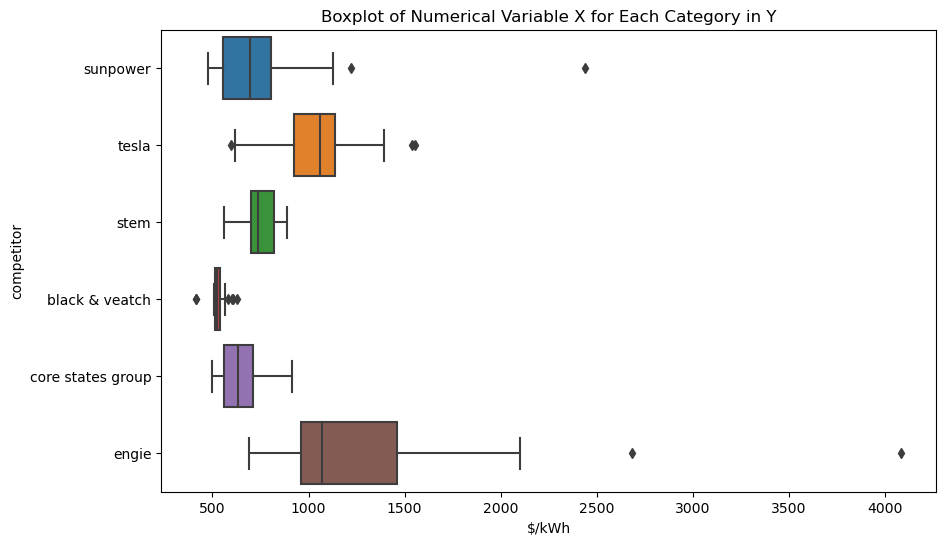

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df2, x='$/kWh', y='competitor')

plt.title('Boxplot of Numerical Variable X for Each Category in Y')
plt.show()

Plot the unit price vs system size again, we can see that after 2021, Tesla sells its systems large than 1MHw with a price level that is around 1000$kWh.
Tesla has the second highest price in the current California market.

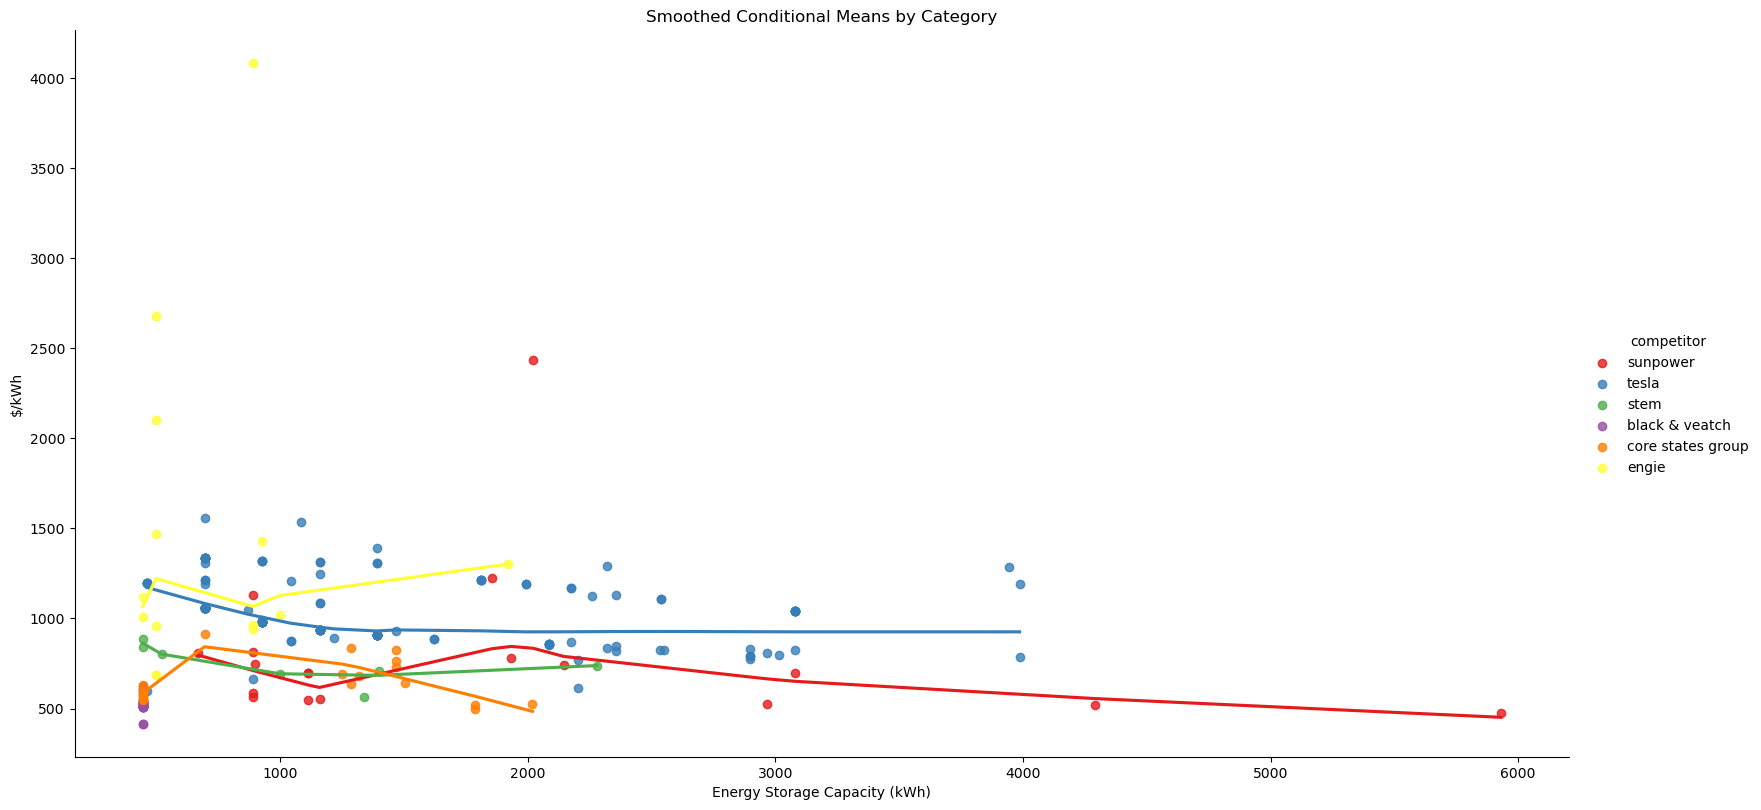

In [34]:
sns.lmplot(x='Energy Storage Capacity (kWh)', y='$/kWh', 
           data=df2[df2['competitor'].isin(important_competitors)], 
           hue='competitor', lowess=True, palette="Set1", 
           height=8, aspect=2)  # Doubled height and aspect

plt.title('Smoothed Conditional Means by Category')
plt.show()

In [35]:
import random

color_dictionary = {}

seaborn_deep_colors = [
    "#4C72B0",  # Blue
    "#DD8452",  # Orange
    "#55A868",  # Green
    "#C44E52",  # Red
    "#8172B3",  # Purple
    "#937860",  # Brown
    "#DA8BC3",  # Pink
    "#8C8C8C",  # Gray
    "#CCB974",  # Yellow
    "#64B5CD",  # Light Blue
    "#A1C9F4",  # pastel blue
    "#FFB482",  # pastel orange
    "#8DE5A1",  # pastel green
    "#D0A2E1",  # pastel purple
    "#FFFEA3",  # pastel yellow
    "#B8B8B8",  # dark gray
    "#FF9F9B",  # dark red
    "#0099CC",  # colorblind blue
    "#FF66CC",  # colorblind pink
    "#6600CC"   # colorblind purple
]

random.shuffle(seaborn_deep_colors)

for i, j in zip(important_competitors, seaborn_deep_colors):
    color_dictionary[i] = j
    
color_dictionary

{'tesla': '#937860',
 'black & veatch': '#C44E52',
 'core states group': '#55A868',
 'sunpower': '#CCB974',
 'engie': '#A1C9F4',
 'stem': '#8C8C8C'}

### Plot $/kWh vs time by competitors: <br>
> For the unit price vs time plot below, we can see that since 2021, with the exception of Black & Veatch, all companies have been increasing its price slowly.

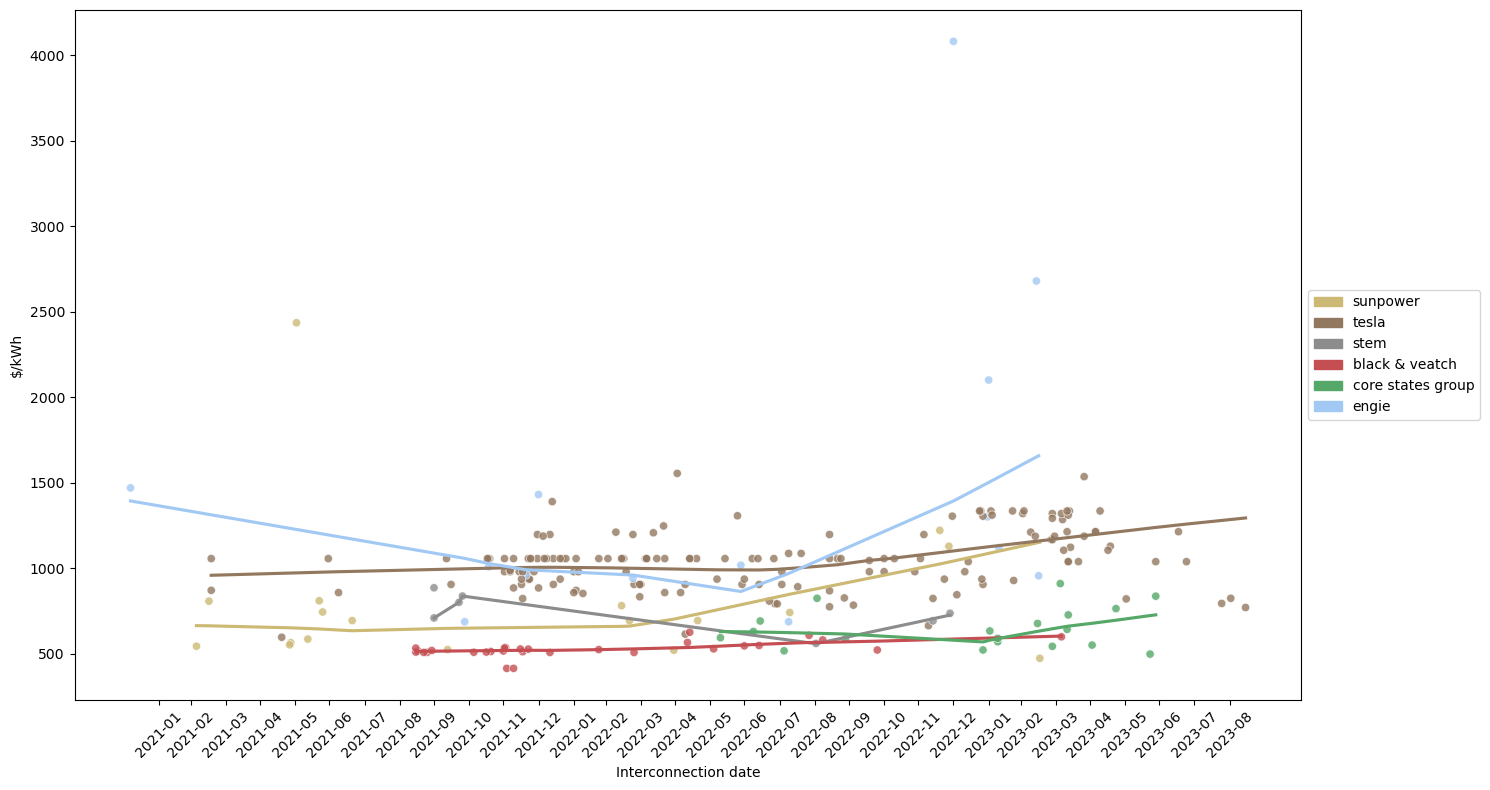

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches  
import pandas as pd

data = df2[df2['competitor'].isin(important_competitors)].copy()

plt.figure(figsize=(15, 8))


competitors = data['competitor'].unique()


for competitor in competitors:
    subset = data[data['competitor'] == competitor]
    

    sns.regplot(x=subset['Interconnection date'].astype('int64'), 
                y=subset['$/kWh'], 
                lowess=True, 
                scatter=False, 
                line_kws={'color': color_dictionary[competitor]})


colors = data['competitor'].map(color_dictionary).tolist()
plt.scatter(data['Interconnection date'].astype('int64'), data['$/kWh'], c=colors, alpha=0.8, edgecolors='w', linewidth=0.5)  # Added edgecolors for clarity


min_date = data['Interconnection date'].min()
max_date = data['Interconnection date'].max()
monthly_dates = pd.date_range(start=min_date, end=max_date, freq='M')


plt.gca().set_xticks(monthly_dates.astype('int64'))
plt.gca().set_xticklabels(monthly_dates.strftime('%Y-%m'), rotation=45)


legend_patches = [mpatches.Patch(color=color_dictionary[competitor], label=competitor) for competitor in competitors]

plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


From the plot below, we can see that despite the increasing price, the sizes of the systems that Tesla is able to sell are increasing.

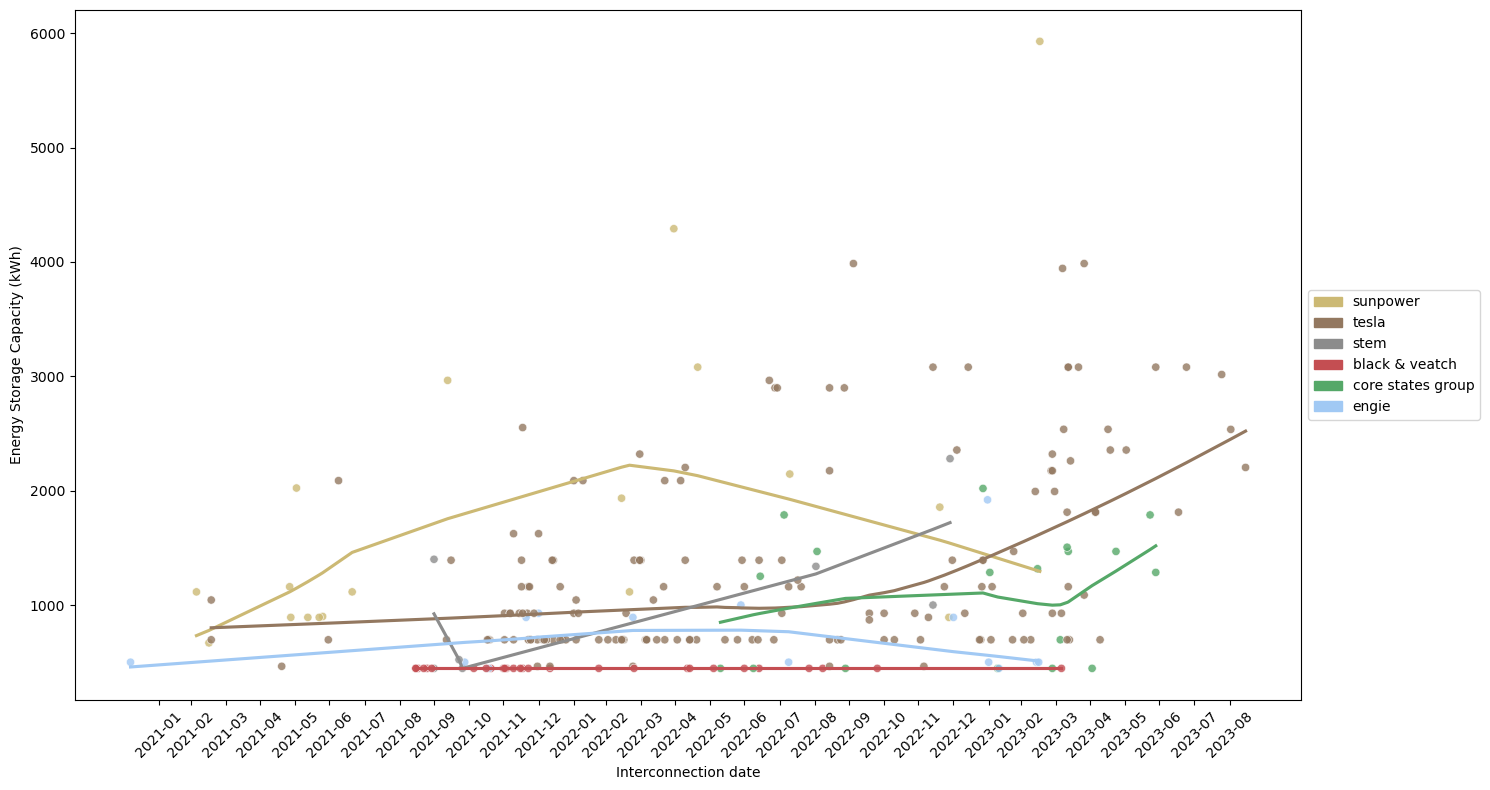

In [37]:
plt.figure(figsize=(15, 8))


competitors = data['competitor'].unique()


for competitor in competitors:
    subset = data[data['competitor'] == competitor]
    

    sns.regplot(x=subset['Interconnection date'].astype('int64'), 
                y=subset['Energy Storage Capacity (kWh)'], 
                lowess=True, 
                scatter=False, 
                line_kws={'color': color_dictionary[competitor]})


colors = data['competitor'].map(color_dictionary).tolist()
plt.scatter(data['Interconnection date'].astype('int64'), data['Energy Storage Capacity (kWh)'], c=colors, alpha=0.8, edgecolors='w', linewidth=0.5)  # Added edgecolors for clarity


min_date = data['Interconnection date'].min()
max_date = data['Interconnection date'].max()
monthly_dates = pd.date_range(start=min_date, end=max_date, freq='M')


plt.gca().set_xticks(monthly_dates.astype('int64'))
plt.gca().set_xticklabels(monthly_dates.strftime('%Y-%m'), rotation=45)


legend_patches = [mpatches.Patch(color=color_dictionary[competitor], label=competitor) for competitor in competitors]

plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

All companies monthly sales have been increasing. The fall-downs at the righter end of the graph could be caused by the following reasons:<br>
> (1)The companies sales fell down.<br>
(2)The newly sold systems have not been approved by the rebate program administrator, thus they were excluded in the data <br>processing at the beginning of this script. (This reason is false, I tried to include the storage systems that are unapproved by the rebate program, but the fall-downs at the end of the graph still exists)<br>
(3) The companies did not apply for the rebate for their clients or got rej (Unlikely). <br>
(4) The companies let third parties install the systems for their clients, thus the data-processing above categorized those sales as sales of other companies. This problem can be solved by first identifying what the batteries are through their system size/system capacity ratio. 

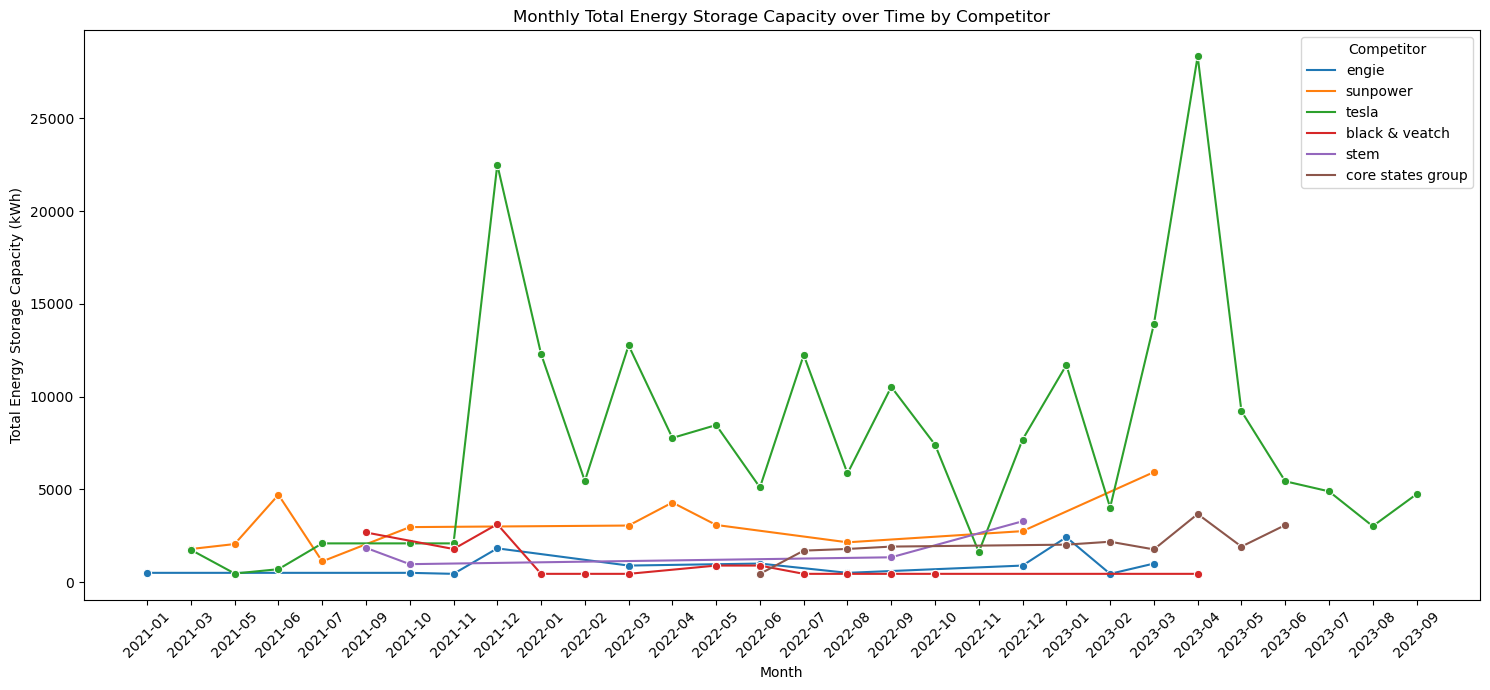

In [38]:

df = pd.DataFrame(data)

df['Interconnection date'] = pd.to_datetime(df['Interconnection date'])

df['Year-Month'] = df['Interconnection date'].dt.to_period('M')

grouped_df = df.groupby(['Year-Month', 'competitor'])['Energy Storage Capacity (kWh)'].sum().reset_index()
grouped_df['Year-Month'] = grouped_df['Year-Month'].astype(str)

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=grouped_df, x='Year-Month', y='Energy Storage Capacity (kWh)', hue='competitor', marker="o")

plt.title('Monthly Total Energy Storage Capacity over Time by Competitor')
plt.xlabel('Month')
plt.ylabel('Total Energy Storage Capacity (kWh)')
plt.legend(title='Competitor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
df['Year-Week'] = df['Interconnection date'].dt.to_period('W')

In [40]:
sales_price_table = df.groupby('Year-Week')[['Total Eligible Costs','Energy Storage Capacity (kWh)']].sum()

In [41]:
sales_price_table['weekly_$/kWh'] = sales_price_table['Total Eligible Costs']/sales_price_table['Energy Storage Capacity (kWh)']

In [42]:
sales_price_table.reset_index(inplace = True)

## There is a negative correlation between price and system size after controlling time.

The regression analysis below shows that as there is a negative correlation between price and the system size and a positive correlation between time and system size, suggesting that a price-demand-model for inital pricing could be explored.<br>
Further regressions analysis shows that there is no interaction between price and time, suggesting that the effect of price on system size is not effect by time. 

In [43]:
data['day_since_2018']= (pd.to_datetime(data['Interconnection date']) - pd.to_datetime('2018-01-01')).dt.days

In [44]:
tesla = data[data['competitor'] == 'tesla']

In [45]:
tesla = tesla[['Energy Storage Capacity (kWh)','Total Eligible Costs','$/kWh','day_since_2018']]

In [46]:
for i in tesla.columns:
    tesla[i] = tesla[i].astype(float)

In [47]:
import statsmodels.api as sm
import numpy as np


tesla['$/kWh * day_since_2018'] = tesla['$/kWh'] * tesla['day_since_2018'] 
X = tesla[['day_since_2018','$/kWh']]
y = tesla['Energy Storage Capacity (kWh)']


In [48]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Energy Storage Capacity (kWh)   R-squared:                       0.420
Model:                                       OLS   Adj. R-squared:                  0.413
Method:                            Least Squares   F-statistic:                     56.94
Date:                           Sat, 21 Oct 2023   Prob (F-statistic):           2.54e-19
Time:                                   23:05:03   Log-Likelihood:                -1258.1
No. Observations:                            160   AIC:                             2522.
Df Residuals:                                157   BIC:                             2531.
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [49]:
X = tesla[['day_since_2018','$/kWh','$/kWh * day_since_2018']]
y = tesla['Energy Storage Capacity (kWh)']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Energy Storage Capacity (kWh)   R-squared:                       0.424
Model:                                       OLS   Adj. R-squared:                  0.413
Method:                            Least Squares   F-statistic:                     38.35
Date:                           Sat, 21 Oct 2023   Prob (F-statistic):           1.27e-18
Time:                                   23:05:03   Log-Likelihood:                -1257.5
No. Observations:                            160   AIC:                             2523.
Df Residuals:                                156   BIC:                             2535.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

## Computing the geographic distribution of different companies services

Importing the longtitude and latitude of all zip codes

In [50]:
zip_codes = pd.read_csv('uszips.csv',dtype={'zip': str})

In [51]:
data = pd.merge(data, zip_codes, left_on = 'Zip', right_on = 'zip')

#### mapping

In [52]:
import folium
import pandas as pd

m = folium.Map(
    location=[data['lat'].mean(), data['lng'].mean()],
    zoom_start=13
)

colors = {
    'tesla': 'red',
    'black & veatch': 'blue',
    'stem': 'green',
    'core states group':'black',
    'sunpower': 'purple',
    'engie': 'yellow'
}

for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=5,  
        color=colors[row['competitor']],
        fill=True,
        fill_opacity=1,
        popup=(row['competitor'],row['Energy Storage Capacity (kWh)'], row['Host Customer Sector'])
    ).add_to(m)

m

## Key take aways:

(1) Tesla has the second highest unit price ($ per kWh) within the large storage system domain (storage systems that are larger than 400kWh), exceeding the third most expensive provider by 43 percent. Tesla's median price is 1045 dollar per kWh, while Stem's median is 737 dollar per kWh. However, Tesla is still the dominant provider in non-metropolitan areas. This suggests that Tesla might not need to consider any form of price war in its current dominant markets, which are non-metropolitan areas and local-government institutions.
<br>


(2) Tesla is giving up market share at metropolitan areas such as Los Angelos City, San Fransico city, and San Dieog to Stem, Sunpower, Black & Veatch, and Core States Group, who are selling 400 – 3000 kWh storage systems to commercial organization. Tesla could create customer portraits of metropolitan commercial customers to explore those areas. The reason for those competitors' dominance at metropolitan areas could be that they offer lower price, and commercial organization are more sensitive to price than does government organizations. Or, they offer systems with more flexible sizes, which fit better into the busy cities, suggesting that Tesla might want to consider creating an alternative systems that is a down-sized version of Megapack.<br>



(3) After controlling the variable 'time', there is a negative correlation between unit price and system size, suggesting that there is potential for making a price-to-demand model for optimal initial pricing when making quotes. <br>



(4) All major large storage providers in California are raising their price levels.<br> 